In [40]:
import numpy as np
from PIL import Image
from scipy.ndimage.filters import correlate
from skimage import transform, io
import matplotlib.pyplot as plt


# random_augmentation takes a numpy array of dimension 2 with entries between 0 and 1, distorts it, and rescales it
# the rest of the functions are helper functions



def rgb_to_grayscale(x):
    # x is an numpy array with shape (a, b, 3)
    a, b, _ = x.shape
    weights = np.array([[0.2125, 0.7154, 0.0721]]).T
    return (x @ weights).reshape(a, b)


########################### augmentation functions ###########################
def clip_left(x, k):
    return x[:, k:]

def clip_right(x, k):
    return x[:, :x.shape[1]-k]

def extend_left(x, k):
    left_col = x[:, 0].reshape(-1, 1)
    tiled = np.tile(left_col, (1, k))
    return np.concatenate([tiled, x], axis=1)

def extend_right(x, k):
    right_col = x[:, 0].reshape(-1, 1)
    tiled = np.tile(right_col, (1, k))
    return np.concatenate([x, tiled], axis=1)

def extend_up(x, k):
    return np.concatenate([np.ones((k, x.shape[1])), x])

def extend_down(x, k):
    return np.concatenate([x, np.ones((k, x.shape[1]))])

def horizontal_jiggle(x, N, p):
    jiggle_direction = np.random.choice([1, -1])
    y = np.random.uniform(size=(N, x.shape[0]))
    for i in range(N):
        mask = y[i] < p
        if jiggle_direction == 1:
            x[mask, 1:] = x[mask, :-1]
        else:
            x[mask, :-1] = x[mask, 1:]
    return x

def vertical_jiggle(x, N, p):
    jiggle_direction = np.random.choice([1, -1])
    y = np.random.uniform(size=(N, x.shape[1]))
    for i in range(N):
        mask = y[i] < p
        if jiggle_direction == 1:
            x[1:, mask] = x[:-1, mask]
        else:
            x[:-1, mask] = x[1:, mask]
    return x

def add_noise(x, p, color='black'):
    if color == 'black':
        noise = np.random.choice([0, 1], size=x.shape, p=[p, 1-p])
        return np.minimum(x, noise)
    else:
        noise = np.random.choice([0, 1], size=x.shape, p=[1-p, p])
        return np.maximum(x, noise)

def make_bw(x):
    return np.around(x)

def convert_to_1(x):
    image = Image.fromarray(x*255)
    image = image.convert('1')
    x = np.array(image)/255
    return x

def thicken(x, dims):
    x = 1-x
    k = np.ones(dims)
    x = np.minimum(correlate(x, k), 1)
    return 1-x

def add_splotch(x, N, r):
    a = np.random.randint(x.shape[0])
    b = np.random.randint(x.shape[1])
    splotch_points = np.around(np.array([a, b]) + np.random.randn(N, 2)*r)
    splotch_points = splotch_points.astype(int)
    for point in splotch_points:
        if 0 <= point[0] < x.shape[0] and 0 <= point[1] < x.shape[1]:
            x[point[0], point[1]] = np.minimum(x[point[0], point[1]], 0)
    return x
            
def shrink_whitespace(x, p):
    white_rows = np.nonzero(x.mean(axis=1) == 1)[0]
    white_rows = white_rows[(white_rows >= int(x.shape[0]*3/8)) & (white_rows < int(x.shape[0]*5/8))]
    excluded_rows = np.random.choice(white_rows, size=int(p*len(white_rows)), replace=False)
    mask = np.ones(x.shape[0])
    mask[excluded_rows] -= 1
    included_rows = np.nonzero(mask)[0]
    return x[included_rows]

def shrink_note_spacing(x, p):
    empty_columns = np.nonzero((1-x).sum(axis=0) <= 12)[0]
    excluded_columns = np.random.choice(empty_columns, size=int(p*len(empty_columns)), replace=False)
    mask = np.ones(x.shape[1])
    mask[excluded_columns] -= 1
    included_columns = np.nonzero(mask)[0]
    return x[:, included_columns]



########################### random augmentation functions ###########################
def random_shrink_whitespace(x):
    p = np.random.rand()
    x = shrink_whitespace(x, p)
    return x
    
def random_shrink_note_spacing(x):
    p = np.minimum(np.abs(np.random.randn()*0.3), 1)
    x = shrink_note_spacing(x, p)
    return x
    
def random_resize(x):
    left = int(np.maximum(-1, x.shape[1]*np.random.randn()*0.1))
    right = int(np.maximum(-10, x.shape[1]*np.random.randn()*0.1))
    vertical_base = np.abs(x.shape[0]*np.random.randn()*0.3)
    top = int(np.maximum(vertical_base + np.random.randn()*0.1, 0))
    bottom = int(np.maximum(vertical_base + np.random.randn()*0.15, 0))
    # top = int(np.abs(x.shape[0]*np.random.randn()*0.3))
    # bottom = int(np.abs(x.shape[0]*np.random.randn()*0.3))
    if left > 0:
        x = extend_left(x, left)
    else:
        x = clip_left(x, np.abs(left))
    if right > 0:
        x = extend_right(x, right)
    else:
        x = clip_right(x, np.abs(right))
    x = extend_up(x, top)
    x = extend_down(x, bottom)
    return x

def random_splotches(x):
    n = np.random.randint(5)
    for _ in range(n):
        N = np.random.randint(200, 300)
        r = np.random.uniform(0.5, 1)
        x = add_splotch(x, N, r)
    return x

def random_noise(x):
    color = np.random.choice(['black', 'white'])
    if color == 'black':
        p = np.abs(np.random.randn()*0.01)
#         p = np.random.uniform(0, 0.01)
    else:
        p = np.random.uniform(0, 0.05)
    x = add_noise(x, p, color)
    return x

def random_jiggle(x):
    N = np.random.randint(0, 2)
    p = np.random.randn()*0.05
    x = vertical_jiggle(x, N, p)
    N = np.random.randint(0, 2)
    p = np.abs(np.random.randn()*0.2)
    x = horizontal_jiggle(x, N, p)
    return x

def random_thicken(x):
    dim_choices = [(2, 1), (1, 2), (2, 2), (3, 3), (3, 4), (4, 3), (4, 4)]
    dims = dim_choices[np.random.randint(len(dim_choices))]
    x = thicken(x, dims)
    return x

########################### put the random augmentation functions together ########################### 
def random_pre_augmentation(x):
    if np.random.rand() < 0.8:
        x = random_shrink_whitespace(x)
    if np.random.rand() < 0.8:
        x = random_shrink_note_spacing(x)
    if np.random.rand() < 0.9:
        x = random_resize(x)
    if np.random.rand() < 0.5:
        x = random_thicken(x)
    if np.random.rand() < 0.3:
        x = random_splotches(x)
    if np.random.rand() < 0.6:
        x = random_noise(x)
    if np.random.rand() < 0.3:
        x = random_jiggle(x)
    if np.random.rand() < 0.3:
        x = transform.rotate(x, np.random.randn()*0.6, cval=1)
    return x

def rescale1(x, height, width):
    x = transform.resize(x, (height, width))
    return x

def rescale2(x, height, width):
    x = transform.rescale(x, (height, width))
    return x

def random_post_augmentation(x):
    if np.random.rand() < 0.5:
        x = random_noise(x)
    if np.random.rand() < 0.5:
        x = random_jiggle(x)
    if np.random.rand() < 0.3:
        x = random_splotches(x)
    return x

def random_augmentation1(x, height, width):
    x = random_pre_augmentation(x)
    x = rescale1(x, height, width)
    x = random_post_augmentation(x)
    return x

def random_augmentation2(x, height, width):
    x = random_pre_augmentation(x)
    x = rescale2(x, height, width)
    x = random_post_augmentation(x)
    return x

In [ ]:
n = np.random.randint(40000)
image = io.imread(f'data/quarter_measure_data/{n}.png')/255
image1 = random_augmentation1(image, 200, 200)
image2 = random_augmentation2(image, 200, 200)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image1, cmap='bone')
axs[1].imshow(image2, cmap='bone')

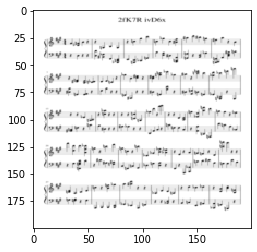

In [47]:
score = io.imread('msc/generation/sample_score-1.png')/255
score_resized = transform.resize(score, (200, 200))
plt.imshow(score_resized)

In [2]:
images = np.load('data/preprocessed/quarter_measure_data_images_preprocessed.npy')

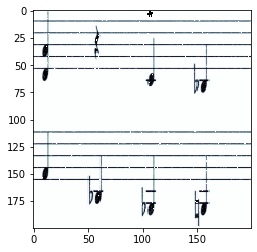

In [38]:
n = np.random.randint(len(images))
plt.imshow(images[n], cmap='bone')